In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as web
import seaborn as sns
import yfinance as yf
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


In [2]:
start = '1926-01-01'

In [3]:
web.famafrench.get_available_datasets(),'F-F_Research_Data_Factors',

(['F-F_Research_Data_Factors',
  'F-F_Research_Data_Factors_weekly',
  'F-F_Research_Data_Factors_daily',
  'F-F_Research_Data_5_Factors_2x3',
  'F-F_Research_Data_5_Factors_2x3_daily',
  'Portfolios_Formed_on_ME',
  'Portfolios_Formed_on_ME_Wout_Div',
  'Portfolios_Formed_on_ME_Daily',
  'Portfolios_Formed_on_BE-ME',
  'Portfolios_Formed_on_BE-ME_Wout_Div',
  'Portfolios_Formed_on_BE-ME_Daily',
  'Portfolios_Formed_on_OP',
  'Portfolios_Formed_on_OP_Wout_Div',
  'Portfolios_Formed_on_OP_Daily',
  'Portfolios_Formed_on_INV',
  'Portfolios_Formed_on_INV_Wout_Div',
  'Portfolios_Formed_on_INV_Daily',
  '6_Portfolios_2x3',
  '6_Portfolios_2x3_Wout_Div',
  '6_Portfolios_2x3_weekly',
  '6_Portfolios_2x3_daily',
  '25_Portfolios_5x5',
  '25_Portfolios_5x5_Wout_Div',
  '25_Portfolios_5x5_Daily',
  '100_Portfolios_10x10',
  '100_Portfolios_10x10_Wout_Div',
  '100_Portfolios_10x10_Daily',
  '6_Portfolios_ME_OP_2x3',
  '6_Portfolios_ME_OP_2x3_Wout_Div',
  '6_Portfolios_ME_OP_2x3_daily',
  '25_Po

In [4]:
ff = web.famafrench.FamaFrenchReader('F-F_Research_Data_Factors', freq='M',start=start).read()

In [5]:
ff

{0:          Mkt-RF   SMB    HML    RF
 Date                              
 1926-07    2.96 -2.38  -2.73  0.22
 1926-08    2.64 -1.47   4.14  0.25
 1926-09    0.36 -1.39   0.12  0.23
 1926-10   -3.24 -0.13   0.65  0.32
 1926-11    2.53 -0.16  -0.38  0.31
 ...         ...   ...    ...   ...
 2021-10    6.65 -2.28  -0.44  0.00
 2021-11   -1.55 -1.35  -0.53  0.00
 2021-12    3.10 -1.57   3.23  0.01
 2022-01   -6.24 -5.87  12.79  0.00
 2022-02   -2.29  2.19   3.12  0.00
 
 [1148 rows x 4 columns],
 1:       Mkt-RF    SMB    HML    RF
 Date                            
 1927   29.47  -2.83  -3.40  3.12
 1928   35.39   4.51  -6.17  3.56
 1929  -19.54 -30.69  11.65  4.75
 1930  -31.23  -5.34 -11.76  2.41
 1931  -45.11   3.64 -14.56  1.07
 ...      ...    ...    ...   ...
 2017   21.51  -4.95 -13.48  0.80
 2018   -6.93  -3.34  -9.80  1.81
 2019   28.28  -6.06 -10.48  2.14
 2020   23.67  12.89 -46.60  0.44
 2021   23.57  -3.80  25.33  0.04
 
 [95 rows x 4 columns],
 'DESCR': 'F-F Research Data F

###### Droping the second elemnet

In [6]:
ff_df = ff[0]

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

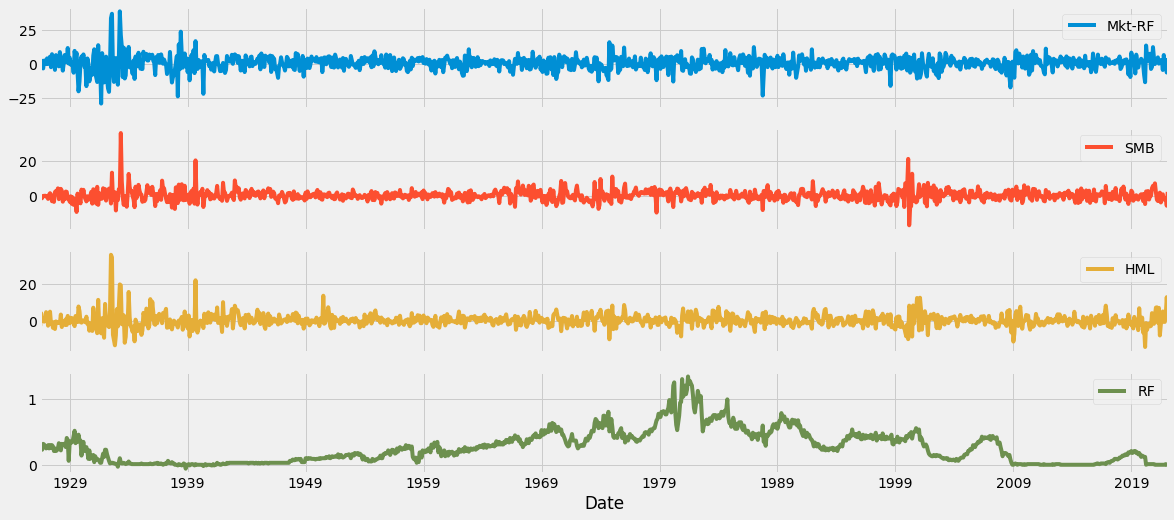

In [7]:
ff_df.plot(subplots=True, figsize=(18,8))

###### Changing to rolling avaerage to decrease the noise

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

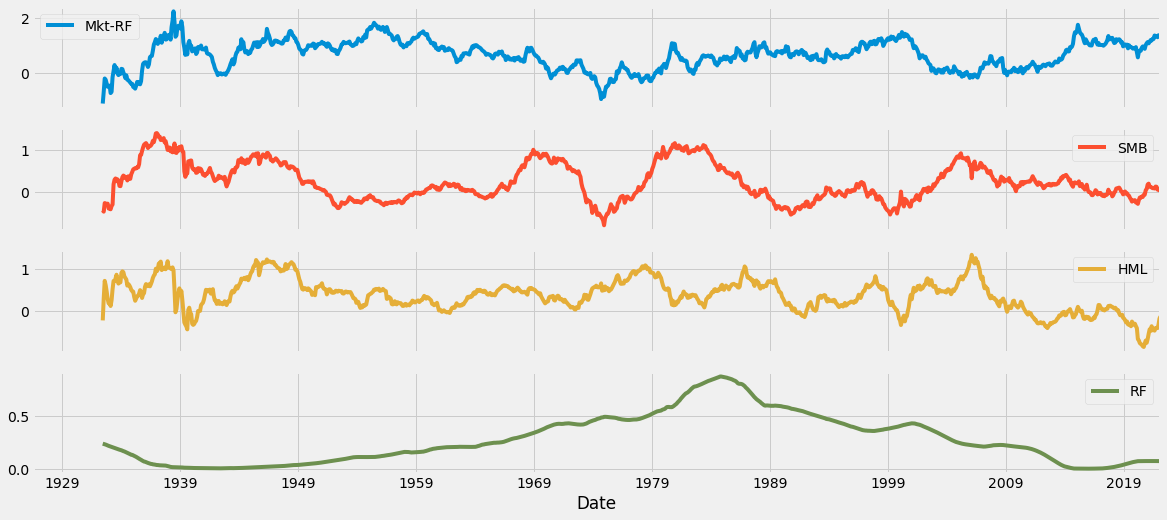

In [8]:
ff_df.rolling(72).mean().plot(subplots=True, figsize=(18,8))

In [9]:
ff_mom_df = web.famafrench.FamaFrenchReader('F-F_Momentum_Factor', freq='M',start=start).read()[0]

array([<AxesSubplot:xlabel='Date'>], dtype=object)

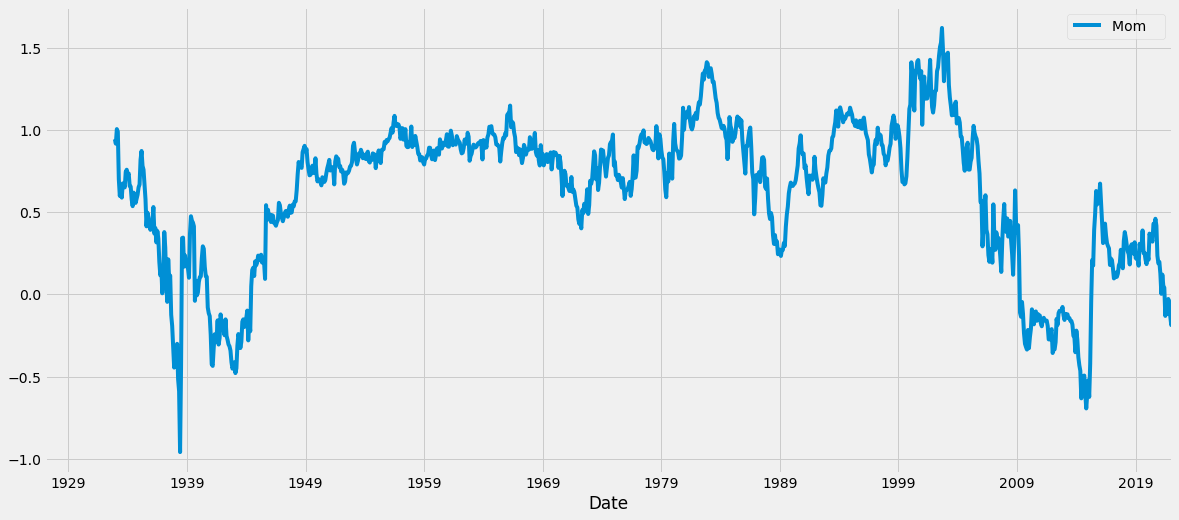

In [10]:
ff_mom_df.rolling(72).mean().plot(subplots=True, figsize=(18,8))

###### Merging data Inner join

In [11]:
ff_df

Mkt-RF   SMB    HML    RF
Date                              
1926-07    2.96 -2.38  -2.73  0.22
1926-08    2.64 -1.47   4.14  0.25
1926-09    0.36 -1.39   0.12  0.23
1926-10   -3.24 -0.13   0.65  0.32
1926-11    2.53 -0.16  -0.38  0.31
...         ...   ...    ...   ...
2021-10    6.65 -2.28  -0.44  0.00
2021-11   -1.55 -1.35  -0.53  0.00
2021-12    3.10 -1.57   3.23  0.01
2022-01   -6.24 -5.87  12.79  0.00
2022-02   -2.29  2.19   3.12  0.00

[1148 rows x 4 columns]

In [12]:
ff_mom_df

Mom   
Date           
1927-01    0.36
1927-02   -2.14
1927-03    3.61
1927-04    4.30
1927-05    3.00
...         ...
2021-10    3.21
2021-11    0.82
2021-12   -2.67
2022-01   -2.53
2022-02    1.74

[1142 rows x 1 columns]

In [13]:
ffac_merged_df = pd.merge(ff_df,
                          ff_mom_df,
                          on='Date',
                          how='inner',
                          sort=True,
                          copy=True,
                          indicator=False,
                          validate='one_to_one')

In [14]:
ffac_merged_df

Mkt-RF   SMB    HML    RF  Mom   
Date                                      
1927-01   -0.06 -0.51   4.73  0.25    0.36
1927-02    4.18 -0.25   3.27  0.26   -2.14
1927-03    0.13 -1.89  -2.56  0.30    3.61
1927-04    0.46  0.49   0.71  0.25    4.30
1927-05    5.44  1.46   4.98  0.30    3.00
...         ...   ...    ...   ...     ...
2021-10    6.65 -2.28  -0.44  0.00    3.21
2021-11   -1.55 -1.35  -0.53  0.00    0.82
2021-12    3.10 -1.57   3.23  0.01   -2.67
2022-01   -6.24 -5.87  12.79  0.00   -2.53
2022-02   -2.29  2.19   3.12  0.00    1.74

[1142 rows x 5 columns]

###### We have the risk factor data ready for our analysis

In [15]:

#Get stock quotes
AAPL_df = web.DataReader('AAPL', data_source='yahoo', start='1970-01-01', end= '2021-12-01')


In [16]:
AAPLdf = AAPL_df['Adj Close']

In [17]:
AAPLdf

Date
1980-12-12      0.100326
1980-12-15      0.095092
1980-12-16      0.088112
1980-12-17      0.090293
1980-12-18      0.092911
                 ...    
2021-11-24    161.733948
2021-11-26    156.610474
2021-11-29    160.036102
2021-11-30    165.089676
2021-12-01    164.560349
Name: Adj Close, Length: 10331, dtype: float64

In [18]:
AAPL_df = AAPLdf.to_frame()

In [19]:
AAPL_df

Adj Close
Date                  
1980-12-12    0.100326
1980-12-15    0.095092
1980-12-16    0.088112
1980-12-17    0.090293
1980-12-18    0.092911
...                ...
2021-11-24  161.733948
2021-11-26  156.610474
2021-11-29  160.036102
2021-11-30  165.089676
2021-12-01  164.560349

[10331 rows x 1 columns]

In [20]:
AAPL_df.index.dtype

dtype('<M8[ns]')

In [21]:
ffac_merged_df.index.dtype

period[M]

###### Tranfer data type to similare

###### Step 1 - create an identical attribute in each dataframe for future merge

In [23]:
AAPL_df['str_date'] = AAPL_df.index.astype(str)
AAPL_df['dt_date'] = pd.to_datetime(AAPL_df['str_date']).dt.strftime('%Y-%m')

In [24]:
AAPL_df.dt_date.dtype

dtype('O')

In [25]:
ffac_merged_df['str_date'] = ffac_merged_df.index.astype(str)
ffac_merged_df['dt_date'] = pd.to_datetime(ffac_merged_df['str_date']).dt.strftime('%Y-%m')

In [26]:
ffac_merged_df.dt_date.dtype

dtype('O')

In [27]:
AAPL_ffac_merge_df = pd.merge(AAPL_df,
                              ffac_merged_df,
                              how='inner',
                              on='dt_date',
                              sort=True,
                              copy=True,
                              indicator = False,
                             )

In [28]:
AAPL_ffac_merge_df

Adj Close  str_date_x  dt_date  Mkt-RF   SMB   HML    RF  Mom     \
0        0.100326  1980-12-12  1980-12   -4.52 -0.26  2.79  1.31   -6.68   
1        0.095092  1980-12-15  1980-12   -4.52 -0.26  2.79  1.31   -6.68   
2        0.088112  1980-12-16  1980-12   -4.52 -0.26  2.79  1.31   -6.68   
3        0.090293  1980-12-17  1980-12   -4.52 -0.26  2.79  1.31   -6.68   
4        0.092911  1980-12-18  1980-12   -4.52 -0.26  2.79  1.31   -6.68   
...           ...         ...      ...     ...   ...   ...   ...     ...   
10326  161.733948  2021-11-24  2021-11   -1.55 -1.35 -0.53  0.00    0.82   
10327  156.610474  2021-11-26  2021-11   -1.55 -1.35 -0.53  0.00    0.82   
10328  160.036102  2021-11-29  2021-11   -1.55 -1.35 -0.53  0.00    0.82   
10329  165.089676  2021-11-30  2021-11   -1.55 -1.35 -0.53  0.00    0.82   
10330  164.560349  2021-12-01  2021-12    3.10 -1.57  3.23  0.01   -2.67   

      str_date_y  
0        1980-12  
1        1980-12  
2        1980-12  
3        1980-12  
4        1980-12  
...          ...  
10326    2021-11  
10327    2021-11  
10328    2021-11  
10329    2021-11  
10330    2021-12  

[10331 rows x 9 columns]

In [29]:
AAPL_ffac_merge_df.drop(columns=['str_date_x','str_date_y'],inplace=True)

In [30]:
AAPL_ffac_merge_df.rename(columns={'Adj Close':'AAPL'},inplace=True)

In [31]:
AAPL_ffac_merge_df.head(50)

AAPL  dt_date  Mkt-RF   SMB   HML    RF  Mom   
0   0.100326  1980-12   -4.52 -0.26  2.79  1.31   -6.68
1   0.095092  1980-12   -4.52 -0.26  2.79  1.31   -6.68
2   0.088112  1980-12   -4.52 -0.26  2.79  1.31   -6.68
3   0.090293  1980-12   -4.52 -0.26  2.79  1.31   -6.68
4   0.092911  1980-12   -4.52 -0.26  2.79  1.31   -6.68
5   0.098581  1980-12   -4.52 -0.26  2.79  1.31   -6.68
6   0.103379  1980-12   -4.52 -0.26  2.79  1.31   -6.68
7   0.107741  1980-12   -4.52 -0.26  2.79  1.31   -6.68
8   0.113412  1980-12   -4.52 -0.26  2.79  1.31   -6.68
9   0.123880  1980-12   -4.52 -0.26  2.79  1.31   -6.68
10  0.125625  1980-12   -4.52 -0.26  2.79  1.31   -6.68
11  0.122572  1980-12   -4.52 -0.26  2.79  1.31   -6.68
12  0.119083  1980-12   -4.52 -0.26  2.79  1.31   -6.68
13  0.120391  1981-01   -5.04  2.92  6.72  1.04   -7.95
14  0.117774  1981-01   -5.04  2.92  6.72  1.04   -7.95
15  0.112539  1981-01   -5.04  2.92  6.72  1.04   -7.95
16  0.107741  1981-01   -5.04  2.92  6.72  1.04   -7.95
17  0.105560  1981-01   -5.04  2.92  6.72  1.04   -7.95
18  0.111231  1981-01   -5.04  2.92  6.72  1.04   -7.95
19  0.110358  1981-01   -5.04  2.92  6.72  1.04   -7.95
20  0.106433  1981-01   -5.04  2.92  6.72  1.04   -7.95
21  0.106869  1981-01   -5.04  2.92  6.72  1.04   -7.95
22  0.109050  1981-01   -5.04  2.92  6.72  1.04   -7.95
23  0.108177  1981-01   -5.04  2.92  6.72  1.04   -7.95
24  0.114720  1981-01   -5.04  2.92  6.72  1.04   -7.95
25  0.111231  1981-01   -5.04  2.92  6.72  1.04   -7.95
26  0.113412  1981-01   -5.04  2.92  6.72  1.04   -7.95
27  0.114720  1981-01   -5.04  2.92  6.72  1.04   -7.95
28  0.114284  1981-01   -5.04  2.92  6.72  1.04   -7.95
29  0.112539  1981-01   -5.04  2.92  6.72  1.04   -7.95
30  0.111667  1981-01   -5.04  2.92  6.72  1.04   -7.95
31  0.108177  1981-01   -5.04  2.92  6.72  1.04   -7.95
32  0.104252  1981-01   -5.04  2.92  6.72  1.04   -7.95
33  0.098581  1981-01   -5.04  2.92  6.72  1.04   -7.95
34  0.092911  1981-02    0.57 -0.34  1.02  1.07   -1.35
35  0.096400  1981-02    0.57 -0.34  1.02  1.07   -1.35
36  0.099889  1981-02    0.57 -0.34  1.02  1.07   -1.35
37  0.099889  1981-02    0.57 -0.34  1.02  1.07   -1.35
38  0.100326  1981-02    0.57 -0.34  1.02  1.07   -1.35
39  0.095092  1981-02    0.57 -0.34  1.02  1.07   -1.35
40  0.095092  1981-02    0.57 -0.34  1.02  1.07   -1.35
41  0.092038  1981-02    0.57 -0.34  1.02  1.07   -1.35
42  0.091165  1981-02    0.57 -0.34  1.02  1.07   -1.35
43  0.088984  1981-02    0.57 -0.34  1.02  1.07   -1.35
44  0.091165  1981-02    0.57 -0.34  1.02  1.07   -1.35
45  0.095092  1981-02    0.57 -0.34  1.02  1.07   -1.35
46  0.089421  1981-02    0.57 -0.34  1.02  1.07   -1.35
47  0.084623  1981-02    0.57 -0.34  1.02  1.07   -1.35
48  0.085931  1981-02    0.57 -0.34  1.02  1.07   -1.35
49  0.082878  1981-02    0.57 -0.34  1.02  1.07   -1.35

In [32]:
AAPL_ffac_merge_df.drop_duplicates(['dt_date'],inplace=True)

###### Transform aapl values to percentage and subtract the risk free rate

In [33]:
AAPL_ffac_merge_df['AAPL_RF']= AAPL_ffac_merge_df['AAPL']*100-AAPL_ffac_merge_df['RF']

In [34]:
AAPL_ffac_merge_df

AAPL  dt_date  Mkt-RF   SMB   HML    RF  Mom          AAPL_RF
0        0.100326  1980-12   -4.52 -0.26  2.79  1.31   -6.68      8.722567
13       0.120391  1981-01   -5.04  2.92  6.72  1.04   -7.95     10.999108
34       0.092911  1981-02    0.57 -0.34  1.02  1.07   -1.35      8.221076
53       0.092911  1981-03    3.56  3.54  0.64  1.21    0.74      8.081076
75       0.084623  1981-04   -2.11  4.40  2.28  1.08   -0.91      7.382269
...           ...      ...     ...   ...   ...   ...     ...           ...
10245  144.905930  2021-08    2.90 -0.48 -0.13  0.00    2.52  14490.592957
10267  152.093964  2021-09   -4.37  0.80  5.09  0.00    1.57  15209.396362
10288  142.260849  2021-10    6.65 -2.28 -0.44  0.00    3.21  14226.084900
10309  148.553650  2021-11   -1.55 -1.35 -0.53  0.00    0.82  14855.364990
10330  164.560349  2021-12    3.10 -1.57  3.23  0.01   -2.67  16456.024851

[493 rows x 8 columns]

In [39]:
import plotly.express as px

df = px.data.stocks(indexed=True)-1
fig = px.bar(df, x=df.index, y="GOOG")
fig.show()

In [40]:
fig = px.area(df, facet_col="company", facet_col_wrap=2)
fig.show()

In [41]:
import plotly.express as px

df = px.data.stocks(indexed=True)-1
fig = px.bar(df, x=df.index, y="NFLX")
fig.show()

In [43]:
import plotly.express as px
df = px.data.stocks()
fig = px.line(df, x="date", y=df.columns,
              hover_data={"date": "|%B %d, %Y"},
              title='FAANG TRACKING')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()

In [44]:
import plotly.express as px
df = px.data.stocks()
fig = px.line(df, x="date", y=df.columns,
              hover_data={"date": "|%B %d, %Y"},
              title='FAANG tracking by period')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y",
    ticklabelmode="period")
fig.show()

In [45]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv')

fig = px.histogram(df, x="Date", y="AAPL.Close", histfunc="avg", title="Histogram on Date Axes")
fig.update_traces(xbins_size="M1")
fig.update_xaxes(showgrid=True, ticklabelmode="period", dtick="M1", tickformat="%b\n%Y")
fig.update_layout(bargap=0.1)
fig.add_trace(go.Scatter(mode="markers", x=df["Date"], y=df["AAPL.Close"], name="daily"))
fig.show()

In [80]:
import plotly.express as px
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv')

fig = px.line(df, x='Date', y='AAPL.High', title='Apple Time Series with Rangeslider')

fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [49]:
#Check for NAs
print(AAPL_ffac_merge_df.isna().values.any())

False


In [50]:
AAPL_ffac_merge_df.columns

Index(['AAPL', 'dt_date', 'Mkt-RF', 'SMB', 'HML', 'RF', 'Mom   ', 'AAPL_RF'], dtype='object')

In [51]:
AAPL_ffac_merge_df.rename(columns={'Mom   ':'Mom'},inplace=True)

###### Regression Model, 'AAPL_RF' as Y (outcome) varialbe, and other four variables is 

In [52]:
from statsmodels.api import OLS
results = OLS(AAPL_ffac_merge_df['AAPL_RF'],AAPL_ffac_merge_df[['Mkt-RF','SMB','HML','Mom']], missing='drop').fit()

C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\statsmodels\compat\pandas.py:65: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



In [53]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                AAPL_RF   R-squared (uncentered):                   0.017
Model:                            OLS   Adj. R-squared (uncentered):              0.009
Method:                 Least Squares   F-statistic:                              2.061
Date:                Thu, 14 Apr 2022   Prob (F-statistic):                      0.0847
Time:                        17:23:25   Log-Likelihood:                         -4640.8
No. Observations:                 493   AIC:                                      9290.
Df Residuals:                     489   BIC:                                      9306.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF        90.6058     31.753      2.853      0.005      28.216     152.996
SMB          -16.2389     46.873     -0.346      0.729    -108.336      75.858
HML           18.5642     47.268      0.393      0.695     -74.310     111.438
Mom           23.6705     31.860      0.743      0.458     -38.929      86.270
==============================================================================
Omnibus:                      355.511   Durbin-Watson:                   0.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3448.910
Skew:                           3.227   Prob(JB):                         0.00
Kurtosis:                      14.236   Cond. No.                         1.88
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

###### Adding a constant

In [54]:
import statsmodels.tools
AAPL_ffac_merge_df_c = statsmodels.tools.add_constant(AAPL_ffac_merge_df,prepend=True)

In [55]:
AAPL_ffac_merge_df_c

const        AAPL  dt_date  Mkt-RF   SMB   HML    RF   Mom  \
0        1.0    0.100326  1980-12   -4.52 -0.26  2.79  1.31 -6.68   
13       1.0    0.120391  1981-01   -5.04  2.92  6.72  1.04 -7.95   
34       1.0    0.092911  1981-02    0.57 -0.34  1.02  1.07 -1.35   
53       1.0    0.092911  1981-03    3.56  3.54  0.64  1.21  0.74   
75       1.0    0.084623  1981-04   -2.11  4.40  2.28  1.08 -0.91   
...      ...         ...      ...     ...   ...   ...   ...   ...   
10245    1.0  144.905930  2021-08    2.90 -0.48 -0.13  0.00  2.52   
10267    1.0  152.093964  2021-09   -4.37  0.80  5.09  0.00  1.57   
10288    1.0  142.260849  2021-10    6.65 -2.28 -0.44  0.00  3.21   
10309    1.0  148.553650  2021-11   -1.55 -1.35 -0.53  0.00  0.82   
10330    1.0  164.560349  2021-12    3.10 -1.57  3.23  0.01 -2.67   

            AAPL_RF  
0          8.722567  
13        10.999108  
34         8.221076  
53         8.081076  
75         7.382269  
...             ...  
10245  14490.592957  
10267  15209.396362  
10288  14226.084900  
10309  14855.364990  
10330  16456.024851  

[493 rows x 9 columns]

In [56]:
results = OLS(AAPL_ffac_merge_df_c['AAPL_RF'],AAPL_ffac_merge_df_c[['const','Mkt-RF','SMB','HML','Mom']].fit()
results.summary

SyntaxError: invalid syntax (<ipython-input-56-661fed61b3be>, line 2)

In [57]:
# Bank of America
BAC = web.DataReader('BAC', data_source='yahoo', start='2006-01-01', end= '2022-1-01')


In [58]:
#CityGroup
C = web.DataReader('C', data_source='yahoo', start='2006-01-01', end= '2022-1-01')


In [59]:
#Goldman Sachs
GS = web.DataReader('GS', data_source='yahoo', start='2006-01-01', end= '2022-1-01')


In [60]:
# J.P. Moregan, Moragn Stanley, Wells Fargo
JPM = web.DataReader('JPM', data_source='yahoo', start='2006-01-01', end= '2022-1-01')
MS = web.DataReader('MS', data_source='yahoo', start='2006-01-01', end= '2022-1-01')
WFC = web.DataReader('WFC', data_source='yahoo', start='2006-01-01', end= '2022-1-01')

In [61]:
tickers = ['BAC','C','GS','JPM','MS', 'WFC']

In [62]:
bank_stocks = pd.concat([BAC,C,GS,JPM,MS,WFC],axis=1,keys=tickers)

In [63]:
bank_stocks

BAC                                                          \
                 High        Low       Open      Close      Volume  Adj Close   
Date                                                                            
2006-01-03  47.180000  46.150002  46.919998  47.080002  16296700.0  33.777512   
2006-01-04  47.240002  46.450001  47.000000  46.580002  17757900.0  33.418789   
2006-01-05  46.830002  46.320000  46.580002  46.639999  14970700.0  33.461819   
2006-01-06  46.910000  46.349998  46.799999  46.570000  12599800.0  33.411591   
2006-01-09  46.970001  46.360001  46.720001  46.599998  15619400.0  33.433121   
...               ...        ...        ...        ...         ...        ...   
2021-12-27  44.820000  44.310001  44.549999  44.639999  33879200.0  44.422798   
2021-12-28  45.080002  44.419998  44.470001  44.700001  32492400.0  44.482510   
2021-12-29  45.119999  44.599998  44.849998  44.630001  25294900.0  44.412849   
2021-12-30  45.099998  44.480000  44.750000  44.529999  23852200.0  44.313335   
2021-12-31  44.720001  44.279999  44.520000  44.490002  24253900.0  44.273533   

                     C                                      ...          MS  \
                  High         Low        Open       Close  ...        Open   
Date                                                        ...               
2006-01-03  493.799988  481.100006  490.000000  492.899994  ...   57.169998   
2006-01-04  491.000000  483.500000  488.600006  483.799988  ...   58.700001   
2006-01-05  487.799988  484.000000  484.399994  486.200012  ...   58.549999   
2006-01-06  489.000000  482.000000  488.799988  486.200012  ...   58.770000   
2006-01-09  487.399994  483.000000  486.000000  483.899994  ...   58.630001   
...                ...         ...         ...         ...  ...         ...   
2021-12-27   60.939999   60.000000   60.400002   60.650002  ...   99.720001   
2021-12-28   61.330002   60.310001   60.439999   60.619999  ...  100.599998   
2021-12-29   60.980000   60.270000   60.810001   60.540001  ...  100.050003   
2021-12-30   61.070000   60.389999   60.619999   60.430000  ...   98.860001   
2021-12-31   60.759998   60.119999   60.430000   60.389999  ...   98.730003   

                                                    WFC                        \
                 Close     Volume  Adj Close       High        Low       Open   
Date                                                                            
2006-01-03   58.310001  5377000.0  35.864342  31.975000  31.195000  31.600000   
2006-01-04   58.349998  7977800.0  35.888939  31.820000  31.365000  31.799999   
2006-01-05   58.509998  5778000.0  35.987347  31.555000  31.309999  31.500000   
2006-01-06   58.570000  6889800.0  36.024246  31.775000  31.385000  31.580000   
2006-01-09   59.189999  4144500.0  36.405602  31.825001  31.555000  31.674999   
...                ...        ...        ...        ...        ...        ...   
2021-12-27  100.400002  4196000.0  99.705193  48.820000  48.080002  48.549999   
2021-12-28   99.970001  4269700.0  99.278168  49.189999  48.360001  48.560001   
2021-12-29   98.730003  6923100.0  98.046753  48.860001  48.369999  48.599998   
2021-12-30   98.800003  3564900.0  98.116264  48.910000  48.040001  48.490002   
2021-12-31   98.160004  5124800.0  97.480698  48.360001  47.840000  48.029999   

                                              
                Close      Volume  Adj Close  
Date                                          
2006-01-03  31.900000  11016400.0  20.353481  
2006-01-04  31.530001  10870000.0  20.117407  
2006-01-05  31.495001  10158000.0  20.095074  
2006-01-06  31.680000   8403800.0  20.213114  
2006-01-09  31.674999   5619600.0  20.209930  
...               ...         ...        ...  
2021-12-27  48.770000  11900400.0  48.552006  
2021-12-28  48.419998  14320500.0  48.203568  
2021-12-29  48.450001  14390700.0  48.233437  
2021-12-30  48.099998  13701300.0  47.884998  
2021-12-31  47.980000  1264930

In [64]:
bank_stocks.columns.names = ['Bank Tickers','Stock Info']

In [65]:
bank_stocks

Bank Tickers        BAC                                               \
Stock Info         High        Low       Open      Close      Volume   
Date                                                                   
2006-01-03    47.180000  46.150002  46.919998  47.080002  16296700.0   
2006-01-04    47.240002  46.450001  47.000000  46.580002  17757900.0   
2006-01-05    46.830002  46.320000  46.580002  46.639999  14970700.0   
2006-01-06    46.910000  46.349998  46.799999  46.570000  12599800.0   
2006-01-09    46.970001  46.360001  46.720001  46.599998  15619400.0   
...                 ...        ...        ...        ...         ...   
2021-12-27    44.820000  44.310001  44.549999  44.639999  33879200.0   
2021-12-28    45.080002  44.419998  44.470001  44.700001  32492400.0   
2021-12-29    45.119999  44.599998  44.849998  44.630001  25294900.0   
2021-12-30    45.099998  44.480000  44.750000  44.529999  23852200.0   
2021-12-31    44.720001  44.279999  44.520000  44.490002  24253900.0   

Bank Tickers                      C                                      ...  \
Stock Info    Adj Close        High         Low        Open       Close  ...   
Date                                                                     ...   
2006-01-03    33.777512  493.799988  481.100006  490.000000  492.899994  ...   
2006-01-04    33.418789  491.000000  483.500000  488.600006  483.799988  ...   
2006-01-05    33.461819  487.799988  484.000000  484.399994  486.200012  ...   
2006-01-06    33.411591  489.000000  482.000000  488.799988  486.200012  ...   
2006-01-09    33.433121  487.399994  483.000000  486.000000  483.899994  ...   
...                 ...         ...         ...         ...         ...  ...   
2021-12-27    44.422798   60.939999   60.000000   60.400002   60.650002  ...   
2021-12-28    44.482510   61.330002   60.310001   60.439999   60.619999  ...   
2021-12-29    44.412849   60.980000   60.270000   60.810001   60.540001  ...   
2021-12-30    44.313335   61.070000   60.389999   60.619999   60.430000  ...   
2021-12-31    44.273533   60.759998   60.119999   60.430000   60.389999  ...   

Bank Tickers          MS                                          WFC  \
Stock Info          Open       Close     Volume  Adj Close       High   
Date                                                                    
2006-01-03     57.169998   58.310001  5377000.0  35.864342  31.975000   
2006-01-04     58.700001   58.349998  7977800.0  35.888939  31.820000   
2006-01-05     58.549999   58.509998  5778000.0  35.987347  31.555000   
2006-01-06     58.770000   58.570000  6889800.0  36.024246  31.775000   
2006-01-09     58.630001   59.189999  4144500.0  36.405602  31.825001   
...                  ...         ...        ...        ...        ...   
2021-12-27     99.720001  100.400002  4196000.0  99.705193  48.820000   
2021-12-28    100.599998   99.970001  4269700.0  99.278168  49.189999   
2021-12-29    100.050003   98.730003  6923100.0  98.046753  48.860001   
2021-12-30     98.860001   98.800003  3564900.0  98.116264  48.910000   
2021-12-31     98.730003   98.160004  5124800.0  97.480698  48.360001   

Bank Tickers                                                          
Stock Info          Low       Open      Close      Volume  Adj Close  
Date                                                                  
2006-01-03    31.195000  31.600000  31.900000  11016400.0  20.353481  
2006-01-04    31.365000  31.799999  31.530001  10870000.0  20.117407  
2006-01-05    31.309999  31.500000  31.495001  10158000.0  20.095074  
2006-01-06    31.385000  31.580000  31.680000   8403800.0  20.213114  
2006-01-09    31.555000  31.674999  31.674999   5619600.0  20.209930  
...                 ...        ...        ...         ...        ...  
2021-12-27    48.080002  48.549999  48.770000  11900400.0  48.552006  
2021-12-28    48.360001  48.560001  48.419998  14320500.0  48.203568  
2021-12-29    48.369999  48.599998  48.450001  14390700.0  48.2334

# EDA

###### Finding the highest closing price for each stock during our analysis timeframe

In [66]:
for tick in tickers:
    print(tick,bank_stocks[tick]['Close'].max())

BAC 54.900001525878906
C 564.0999755859375
GS 423.8500061035156
JPM 171.77999877929688
MS 105.44999694824219
WFC 65.93000030517578


In [67]:
bank_stocks.xs(key='Close',axis=1,level='Stock Info').max()

Bank Tickers
BAC     54.900002
C      564.099976
GS     423.850006
JPM    171.779999
MS     105.449997
WFC     65.930000
dtype: float64

Create empty dataframe call returnes

In [68]:
returns =pd.DataFrame()

In [69]:
for tick in tickers:
    returns[tick+' Return'] = bank_stocks[tick]['Close'].pct_change()

In [70]:
returns.head()

BAC Return  C Return  GS Return  JPM Return  MS Return  WFC Return
Date                                                                          
2006-01-03         NaN       NaN        NaN         NaN        NaN         NaN
2006-01-04   -0.010620 -0.018462  -0.013812   -0.014183   0.000686   -0.011599
2006-01-05    0.001288  0.004961  -0.000393    0.003029   0.002742   -0.001110
2006-01-06   -0.001501  0.000000   0.014169    0.007046   0.001025    0.005874
2006-01-09    0.000644 -0.004731   0.012030    0.016242   0.010586   -0.000158

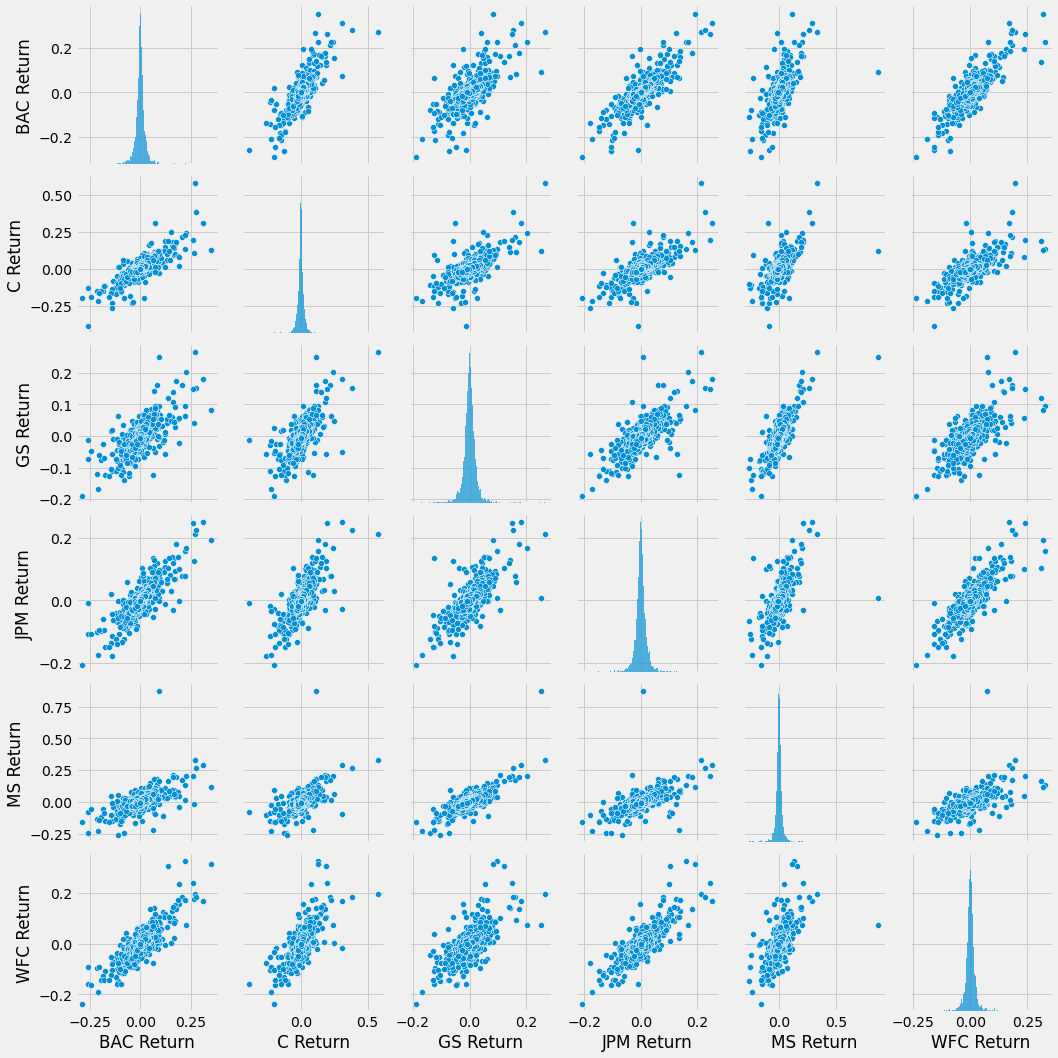

In [72]:
sns.pairplot(returns[1:],palette='ksv')